In [2]:
import pandas as pd
import geopandas as gpd
import os
import numpy as np
import matplotlib.pyplot as plt
from shapely import Point, wkt
import osmnx as ox

random_seed = 100

london = ox.geocode_to_gdf('Greater London, UK')
london.to_crs(epsg=27700, inplace=True)

In [45]:
df = pd.read_csv('data/cleaned/df_ml_tb_rail.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17342 entries, 0 to 17341
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id_code                    17342 non-null  object 
 1   geometry                   17342 non-null  object 
 2   population                 17342 non-null  float64
 3   poi_banking                17342 non-null  float64
 4   poi_hotels                 17342 non-null  float64
 5   poi_leisure_active         17342 non-null  float64
 6   poi_leisure_entertainment  17342 non-null  float64
 7   poi_leisure_outdoor        17342 non-null  float64
 8   poi_medical                17342 non-null  float64
 9   poi_nature                 17342 non-null  float64
 10  poi_public_facilities      17342 non-null  float64
 11  poi_religious              17342 non-null  float64
 12  poi_restaurants            17342 non-null  float64
 13  poi_shopping               17342 non-null  flo

In [46]:
# define target variable columns
targets = ['Total_railbus','Total_bus','Total_rail']

# define feature columns
features = ['population', 
            'poi_banking', 'poi_hotels','poi_leisure_active', 'poi_leisure_entertainment','poi_leisure_outdoor',
            'poi_medical', 'poi_nature', 'poi_public_facilities', 'poi_religious','poi_restaurants','poi_tourism','poi_shopping',
            'transport_bus','transport_rail','transport_other',
            'diversity_poi','diversity_transp_mode','diversity_transp_opt',
            'bus_degree','bus_closeness_t','bus_betweenness_t',
            'rail_degree','rail_closeness_t','rail_betweenness_t'
            ]

In [5]:
# !pip install hdbscan

In [47]:
# HDBSCAN clustering
import hdbscan
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# standardize features
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

In [49]:
df[features]

,population,poi_banking,poi_hotels,poi_leisure_active,poi_leisure_entertainment,poi_leisure_outdoor,poi_medical,poi_nature,poi_public_facilities,poi_religious,...,transport_other,diversity_poi,diversity_transp_mode,diversity_transp_opt,bus_degree,bus_closeness_t,bus_betweenness_t,rail_degree,rail_closeness_t,rail_betweenness_t
0,-1.337527,-0.295426,-0.259965,-1.116824,-0.330038,-0.703990,-0.511620,-0.415895,-1.396747,-0.478298,...,-0.348847,1.481627,0.936591,-2.618307,-0.795547,-0.303998,-0.643644,2.397220,1.197045,1.913181
1,-0.850614,-0.739486,-0.134306,-1.043410,-0.330038,-0.605446,-0.977472,-0.583430,-1.396747,-0.722489,...,-0.348847,0.072958,0.159233,0.114346,1.075148,-1.801151,0.047532,-0.971073,-1.194830,-0.599077
2,1.036867,0.592695,-0.197135,0.351458,-0.088712,0.182902,0.303622,-0.778888,-0.310612,0.498462,...,-0.348847,0.736210,-0.251761,0.500920,0.950435,1.374502,-0.610688,0.151692,0.872466,0.135127
3,-0.481089,0.000615,-0.134306,-1.043410,-0.330038,-1.065316,-0.395156,-0.806811,-1.095043,-0.722489,...,-0.348847,0.993405,-0.347363,0.253822,0.077444,1.333407,-0.618840,0.713074,0.872466,0.151282
4,0.523981,0.444675,-0.197135,0.571700,-0.088712,0.807011,0.070696,-0.555508,0.534160,0.498462,...,-0.348847,0.897625,0.328385,0.114346,0.950435,1.709492,1.091652,1.274456,0.743413,0.827443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17337,-1.377771,4.441220,0.996619,-1.043410,0.635265,-0.802533,1.817642,-0.415895,1.559955,2.940364,...,-0.348847,-0.502071,-0.008876,1.826058,0.576296,0.567142,-0.566647,3.519984,1.582108,4.638224
17338,-0.783498,-0.443446,-0.385623,0.461579,0.393939,2.712186,-1.093935,4.051714,-0.672657,-0.234108,...,0.141895,0.102987,1.473856,-0.396125,-0.670834,0.567230,1.017752,4.081366,1.357460,4.770853
17339,1.188971,-0.739486,-0.197135,1.746326,-0.088712,0.051511,-0.162230,2.292593,0.322967,1.719413,...,-0.294320,0.875943,0.193083,-0.610171,-0.670834,-0.297996,-0.550307,-0.971073,-1.194830,-0.599077
17340,0.027425,-0.147406,0.305498,1.012185,-0.088712,0.872707,-0.045767,2.097135,0.172115,0.010082,...,-0.348847,1.019558,-0.081924,-0.396125,-0.920260,-0.643164,-0.572505,-0.971073,-1.194830,-0.599077


In [50]:
min_clust_list = []
n_clust_list = []
outliers_list = []

for i in range(5, 51):
    clusterer = hdbscan.HDBSCAN(min_cluster_size=i)
    clusterer.fit(df[features])
    labels = clusterer.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    print('Number of clusters: ', n_clusters, 'for min_cluster_size = ', i)
    print('Outliers: ', sum(labels == -1))

    min_clust_list.append(i)
    n_clust_list.append(n_clusters)
    outliers_list.append(sum(labels == -1))

Number of clusters:  626 for min_cluster_size =  5
Outliers:  9336
Number of clusters:  468 for min_cluster_size =  6
Outliers:  10311
Number of clusters:  2 for min_cluster_size =  7
Outliers:  104
Number of clusters:  2 for min_cluster_size =  8
Outliers:  122
Number of clusters:  2 for min_cluster_size =  9
Outliers:  115
Number of clusters:  2 for min_cluster_size =  10
Outliers:  225
Number of clusters:  2 for min_cluster_size =  11
Outliers:  185
Number of clusters:  11 for min_cluster_size =  12
Outliers:  1189
Number of clusters:  3 for min_cluster_size =  13
Outliers:  746
Number of clusters:  3 for min_cluster_size =  14
Outliers:  804
Number of clusters:  17 for min_cluster_size =  15
Outliers:  3729
Number of clusters:  15 for min_cluster_size =  16
Outliers:  3795
Number of clusters:  14 for min_cluster_size =  17
Outliers:  3891
Number of clusters:  2 for min_cluster_size =  18
Outliers:  287
Number of clusters:  2 for min_cluster_size =  19
Outliers:  244
Number of clust

In [ ]:
fig, ax = plt.subplots()
plt.title('HDBSCAN clustering')
# both axes
ax.plot(min_clust_list, n_clust_list, label='Number of clusters')
ax.plot(min_clust_list, outliers_list, label='Outliers')
ax.set_xlabel('min_cluster_size')
ax.set_ylabel('Number of clusters')
ax.legend()
plt.show()


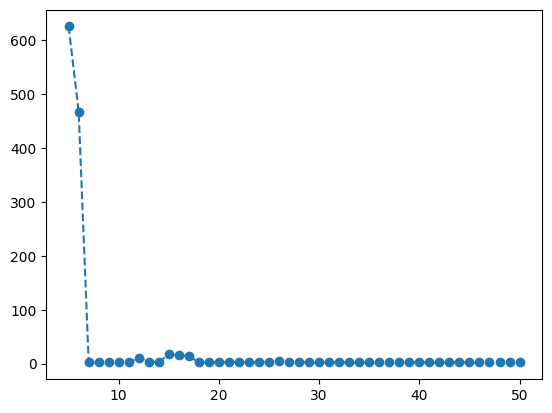

In [51]:
plt.plot(min_clust_list, n_clust_list, marker='o', linestyle='--')

In [52]:
# choose min_cluster_size = 12

clusterer = hdbscan.HDBSCAN(min_cluster_size=12)
clusterer.fit(df[features])
labels = clusterer.labels_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

print('Number of clusters: ', n_clusters)
print('Number of outliers: ', sum(labels == -1))

df['cluster_hdbscan'] = labels.astype(str)
df['cluster_hdbscan_prob'] = clusterer.probabilities_

Number of clusters:  11
Number of outliers:  1189


In [53]:
df['geometry'] = df['geometry'].apply(wkt.loads)
df = gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:27700')

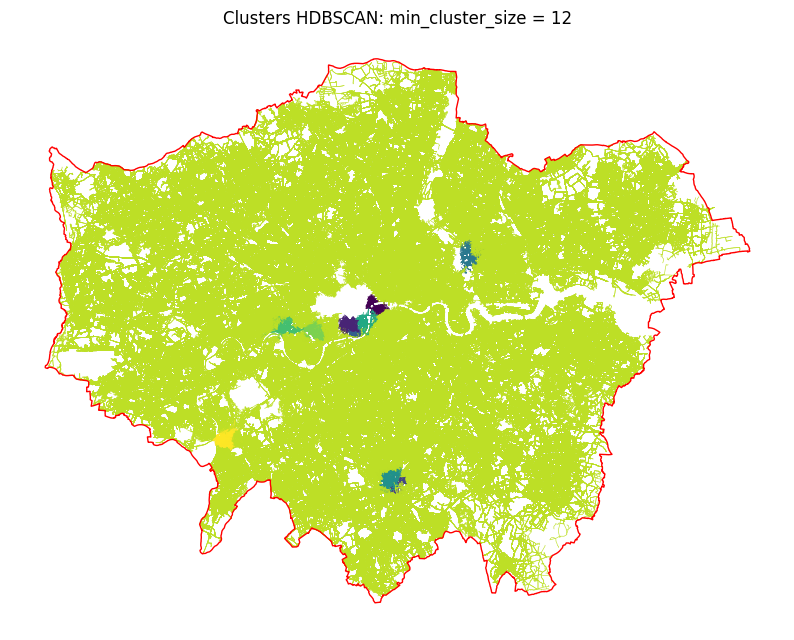

In [54]:
# visualize clusters
fig, ax = plt.subplots(figsize=(10,10))
df[df.cluster_hdbscan != '-1'].plot(column='cluster_hdbscan', ax=ax, cmap='viridis')
london.boundary.plot(ax=ax, color='red', linewidth=1)

plt.title('Clusters HDBSCAN: min_cluster_size = 12')
plt.axis('off')
plt.show()

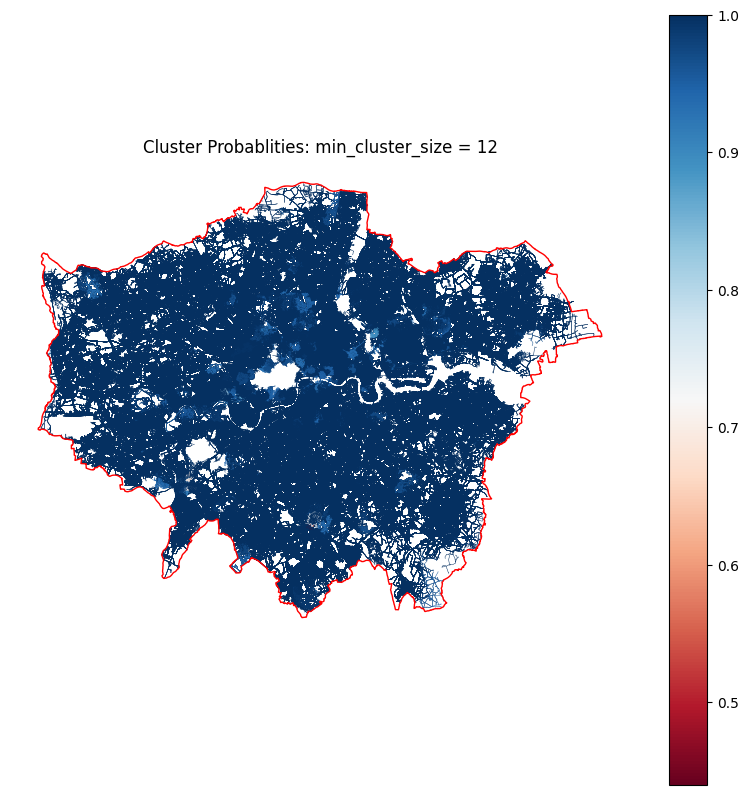

In [55]:
# visualize clusters
fig, ax = plt.subplots(figsize=(10,10))
df[df.cluster_hdbscan_prob != 0].plot(column='cluster_hdbscan_prob', ax=ax, legend=True, cmap='RdBu')
london.boundary.plot(ax=ax, color='red', linewidth=1)

plt.title('Cluster Probablities: min_cluster_size = 12')
plt.axis('off')
plt.show()

In [59]:
# Interpret cluster properties
# get cluster properties
df_clustered = df[features + ['cluster_hdbscan']]
cluster_properties = df_clustered.groupby('cluster_hdbscan').mean()
cluster_properties

,population,poi_banking,poi_hotels,poi_leisure_active,poi_leisure_entertainment,poi_leisure_outdoor,poi_medical,poi_nature,poi_public_facilities,poi_religious,...,transport_other,diversity_poi,diversity_transp_mode,diversity_transp_opt,bus_degree,bus_closeness_t,bus_betweenness_t,rail_degree,rail_closeness_t,rail_betweenness_t
cluster_hdbscan,,,,,,,,,,,,,,,,,,,,,
-1,-0.356411,1.187266,1.691227,-0.081957,1.316010,0.459857,1.039426,0.606836,1.007854,0.445681,...,0.705462,-0.174656,0.951764,0.757782,0.824044,0.639545,0.258458,1.310811,0.881206,1.482489
0,-1.227960,3.146043,2.363153,-0.596807,9.946416,-0.359087,0.284211,-0.038941,2.296616,0.640906,...,-0.330671,0.283755,0.471124,2.496553,3.195270,0.684599,0.171057,2.397220,1.553629,3.798627
1,-0.878219,2.072897,4.273159,-0.826838,1.250645,-0.636652,1.450783,-0.312582,1.416645,-0.185270,...,7.931064,0.412321,1.845101,2.251334,2.397106,1.108735,0.028027,1.274456,1.449230,1.100393
10,-0.861386,4.483511,0.498473,-0.993593,2.117694,-1.161513,0.428404,-0.744982,0.581571,0.533347,...,4.266466,-0.776024,2.106181,1.940412,1.075148,-0.256644,3.986365,-0.409690,0.027411,-0.599077
2,0.396860,0.865963,4.616545,-0.057967,0.096923,0.182902,2.292453,0.827733,2.620562,-0.158973,...,3.673561,1.171634,2.247300,0.705589,0.969622,0.988625,0.050772,1.274456,1.449230,1.100393
3,-1.137603,1.264479,0.728386,-0.355859,0.718801,-0.626924,0.429044,-0.453483,-0.049521,0.179137,...,3.203791,0.429748,1.949739,0.949827,-0.061659,0.287390,0.330195,4.081366,1.357460,4.770853
4,0.182008,4.091892,0.282879,-0.918606,1.658486,-0.728954,0.862645,-0.613587,0.458131,3.370139,...,4.901004,-0.883193,2.009780,1.814316,0.950435,-0.345840,0.439546,-0.409690,0.027411,-0.599077
5,-0.532594,0.605030,0.986147,-0.887405,0.313497,0.442947,1.633242,0.389205,2.455011,0.763002,...,0.564479,0.865277,1.593384,1.426876,1.251825,0.836805,-0.342885,1.648711,1.557105,3.310810
6,-0.439684,1.180001,1.835692,-0.047583,0.829882,-0.502664,1.160189,-0.560011,1.100586,0.033713,...,4.875183,0.854643,2.022634,1.470483,2.881476,1.626719,3.433754,1.491765,0.944653,1.014527


In [ ]:
# create a data frame with clusters and dissolve geometry
df_hdb_merge = df[['cluster_hdbscan', 'geometry']]
df_hdb_merge = df_hdb_merge.dissolve(by='cluster_hdbscan')
df_hdb_merge = df_hdb_merge.reset_index()
# merge cluster properties
df_hdb_merge = df_hdb_merge.merge(cluster_properties, on='cluster_hdbscan')
print(df_hdb_merge.shape)
df_hdb_merge

In [ ]:
# visualize clusters
import folium
from folium.plugins import MarkerCluster

m = folium.Map(location=[51.5074, -0.1278], zoom_start=10)

for i in range(len(df_hdb_merge)):
    folium.GeoJson(df_hdb_merge.loc[i, 'geometry']).add_to(m)

m

In [77]:
# count number of members in each cluster
cluster_count = df.groupby('cluster_hdbscan').size().reset_index(name='count')
cluster_count


,cluster_hdbscan,count
0,-1,1189
1,0,12
2,1,20
3,10,14
4,2,13
5,3,26
6,4,25
7,5,12
8,6,31
9,7,18


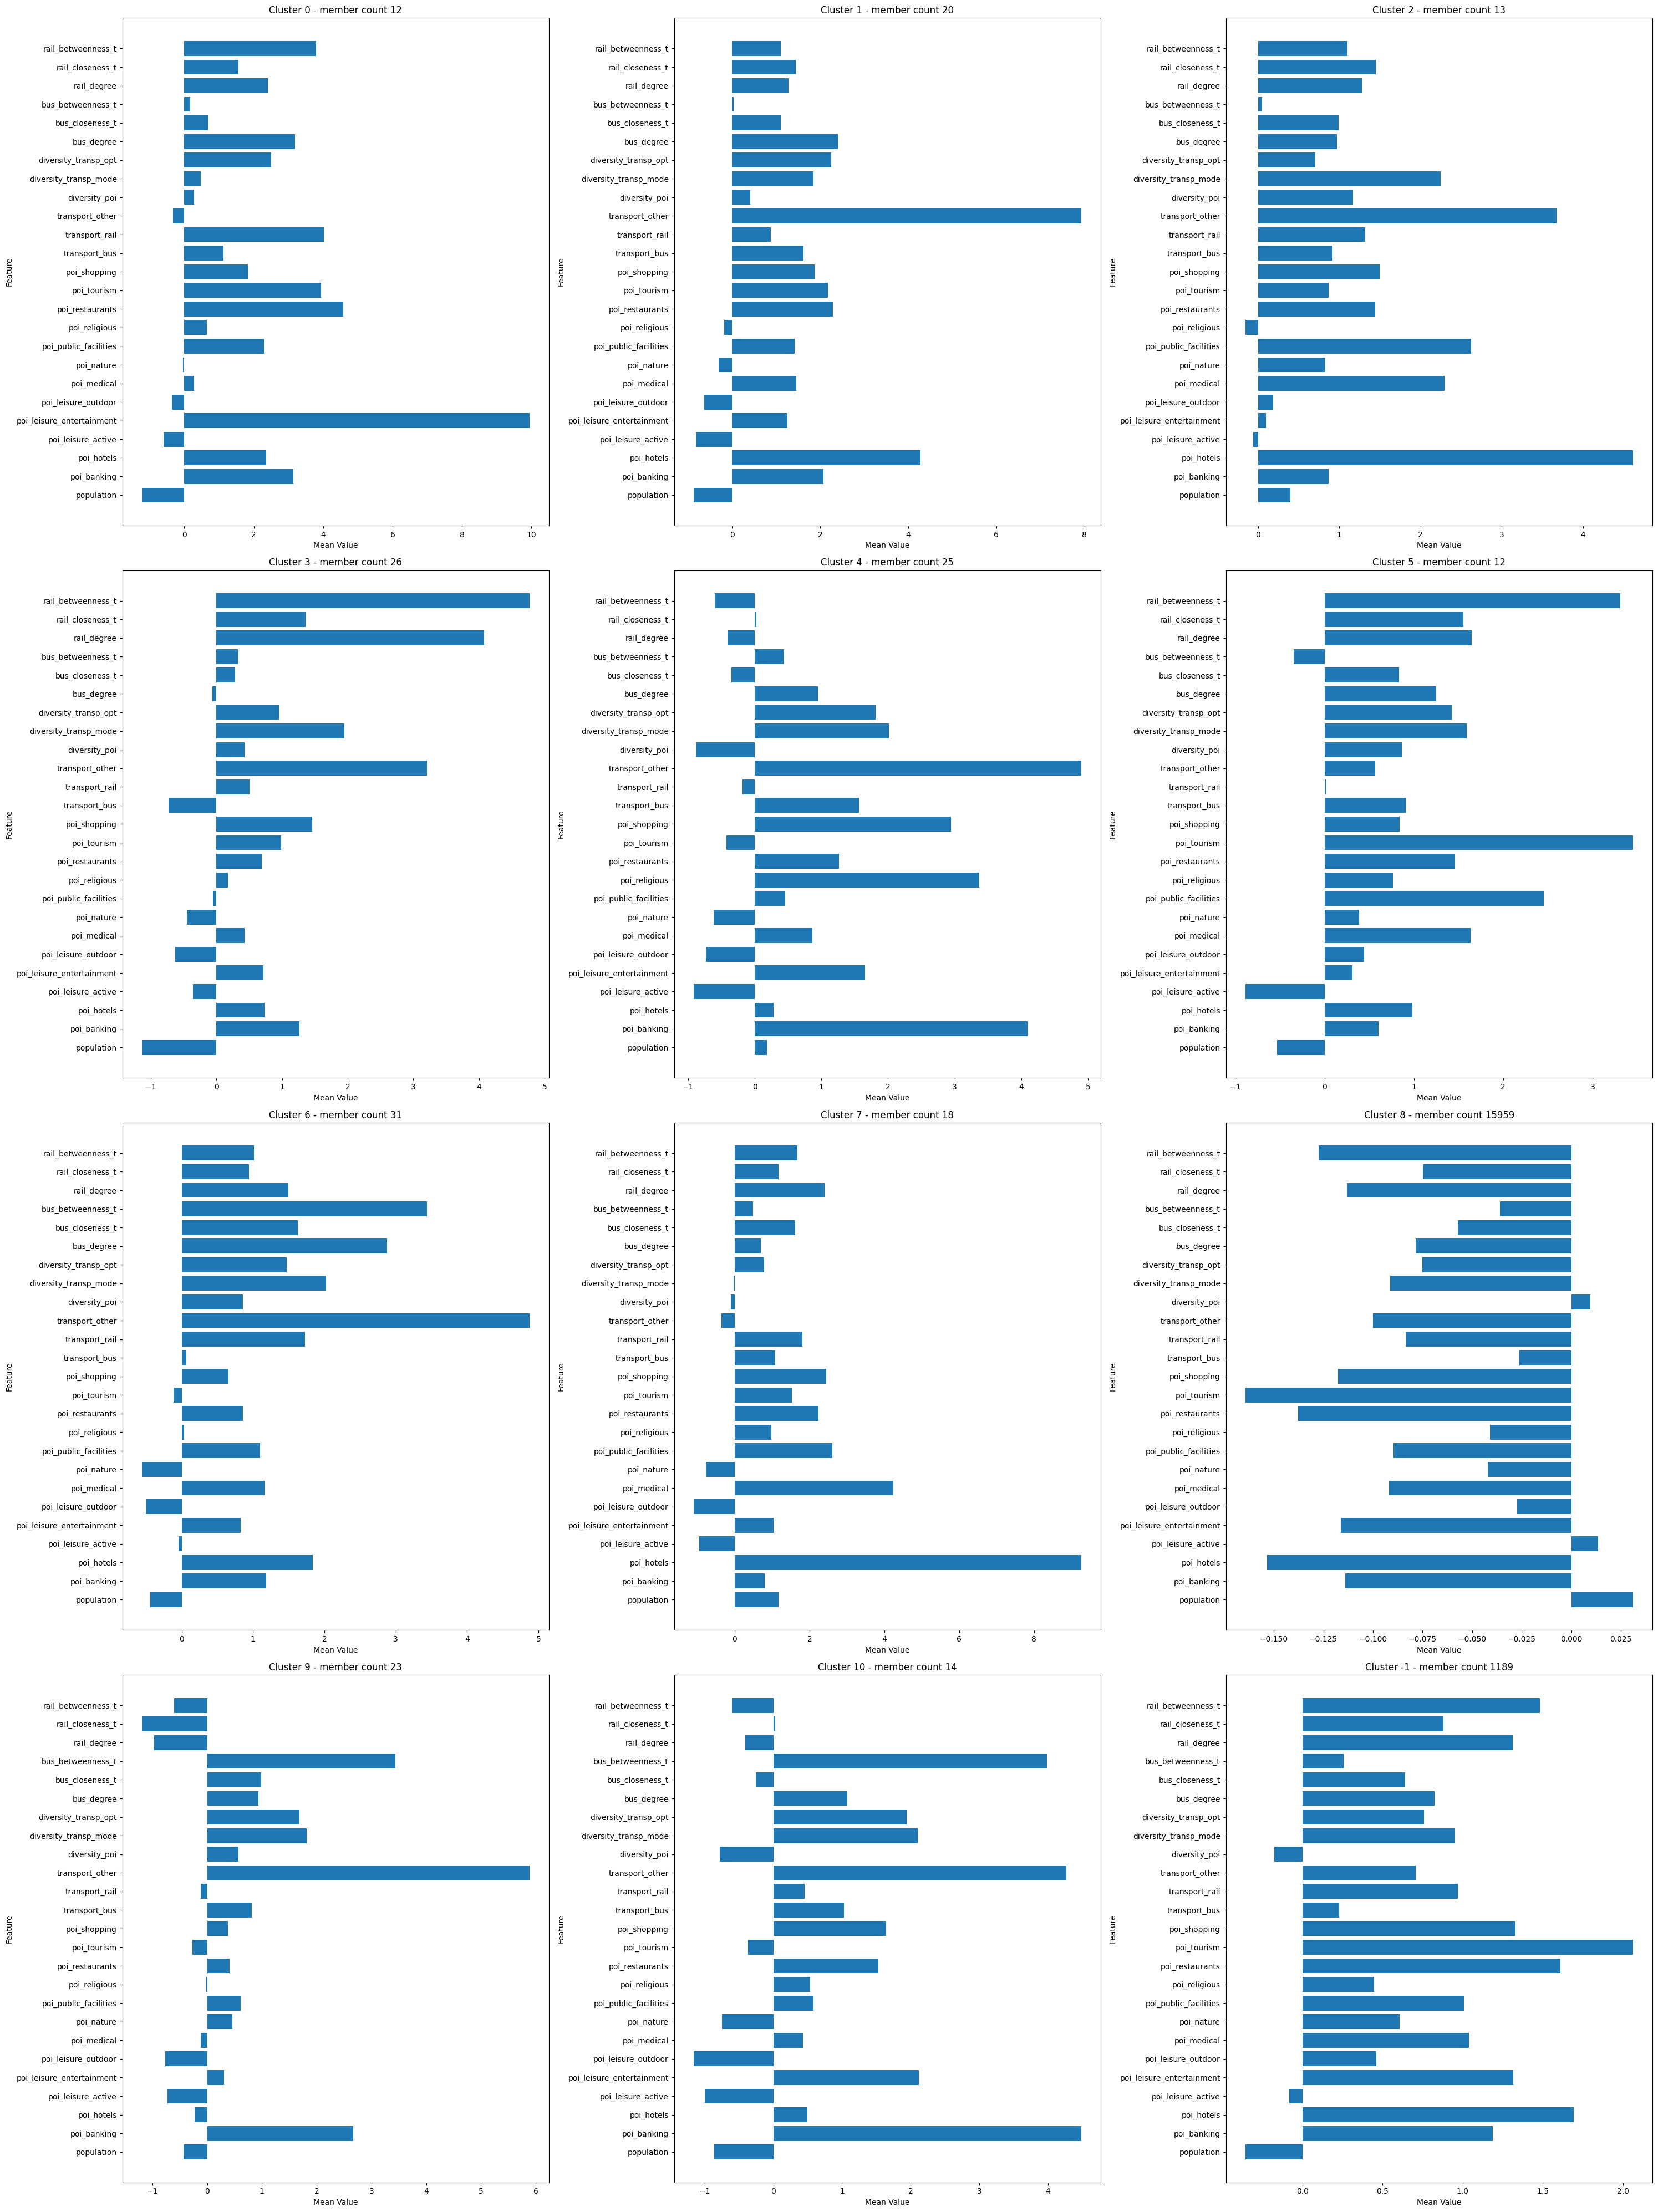

In [78]:
# Interpret cluster properties
# visualize cluster properties for the first 10 largest clusters
fig, ax = plt.subplots(4, 3, figsize=(30,40))
for i in range(-1, 11):
    ax[i//3, i%3].barh(cluster_properties.columns, cluster_properties.loc[str(i)].values)
    ax[i//3, i%3].set_title(f'Cluster {str(i)} - member count {cluster_count[cluster_count.cluster_hdbscan == str(i)].iloc[0,1]}')
    ax[i//3, i%3].set_xlabel('Mean Value')
    ax[i//3, i%3].set_ylabel('Feature')
plt.tight_layout()
plt.show()

# Dimensionality Reduction

In [62]:
# # Dimensionality reduction
# from sklearn.decomposition import PCA

# # skee plot
# pca = PCA()
# pca.fit(df_clustered[features])
# plt.plot(np.cumsum(pca.explained_variance_ratio_))
# # knee point
# plt.axvline(x=10, color='red', linestyle='--')
# plt.title('PCA Scree Plot')
# plt.xlabel('Number of components')
# plt.ylabel('Cumulative explained variance')
# plt.show()

In [63]:
# # PCA with 10 components
# pca = PCA(n_components=10)
# df_pca = pca.fit_transform(df_clustered[features])
# df_pca = pd.DataFrame(df_pca, columns=['PC' + str(i) for i in range(1, 11)])
# df_pca

In [64]:
# # find best eps and min_samples for DBSCAN
# from sklearn.neighbors import NearestNeighbors
# from kneed import KneeLocator

# neigh = NearestNeighbors(n_neighbors=2)
# nbrs = neigh.fit(df_pca)
# distances, indices = nbrs.kneighbors(df_pca)
# distances = np.sort(distances, axis=0)
# distances = distances[:,1]

# # find knee
# kl = KneeLocator(range(1, len(distances)+1), distances, curve='convex', direction='increasing')
# kl.plot_knee()

# plt.title('K-distance Graph')
# plt.xlabel('Data Points')
# plt.ylabel('Epsilon')

# # kneepoint is at 
# best_eps = kl.knee_y

In [65]:
# # DBSCAN clustering
# clusterer = DBSCAN(eps=best_eps, min_samples=5)
# clusterer.fit(df_pca)
# labels = clusterer.labels_
# n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

# print('Number of clusters: ', n_clusters)
# print('Number of outliers: ', sum(labels == -1))

In [66]:
# min_clust_list = []
# n_clust_list = []

# for i in range(1, 31):
#     clusterer = DBSCAN(eps=best_eps, min_samples=i)
#     clusterer.fit(df_pca)
#     labels = clusterer.labels_
#     n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
#     print('Number of clusters: ', n_clusters, 'for min_samples = ', i)
#     print('Number of outliers: ', sum(labels == -1))

#     min_clust_list.append(i)
#     n_clust_list.append(n_clusters)

In [67]:
# plot
# plt.plot(min_clust_list, n_clust_list, marker='o', linestyle='--')

In [68]:
# clusterer = DBSCAN(eps=best_eps, min_samples=5)
# clusterer.fit(df_pca)
# labels = clusterer.labels_
# n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
# print('Number of clusters: ', n_clusters, 'for min_samples = 5')
# print('Number of outliers: ', sum(labels == -1))

In [69]:
# # cluster size
# cluster_sizes = df['cluster_pca'].value_counts().reset_index()
# cluster_sizes.columns = ['cluster', 'size']
# cluster_sizes = cluster_sizes.sort_values(by='size', ascending=False)
# cluster_sizes = cluster_sizes.reset_index(drop=True)
# cluster_sizes


In [70]:
# df['cluster_pca'] = labels.astype(str)

# # visualize clusters
# fig, ax = plt.subplots(figsize=(10,10))
# df[df.cluster_pca != '-1'].plot(column='cluster_pca', ax=ax, cmap='viridis',legend=True)
# london.boundary.plot(ax=ax, color='red', linewidth=1)

# plt.title('Clusters')
# plt.axis('off')
# plt.show()

In [71]:
# # create a data frame with clusters and merge geometry
# df_merge = df[['cluster_pca', 'geometry']]
# df_merge = df_merge.dissolve(by='cluster_pca')
# df_merge = df_merge.reset_index()
# df_merge

In [72]:
# # visualize clusters
# import folium
# m = folium.Map(location=[51.5074, -0.1278], zoom_start=10, tiles='cartodbpositron')
# for i in range(len(df_merge)):
#     folium.GeoJson(df_merge.loc[i, 'geometry'], tooltip=df_merge.loc[i, 'cluster_pca']).add_to(m)

# m

In [75]:
# df_clustered_pca = df[features + ['cluster_pca']]
# df_clustered_pca.info()

In [76]:
# # Interpret cluster properties
# # get cluster properties
# cluster_properties = df_clustered_pca.groupby('cluster_pca').mean()

# # visualize cluster properties for the first 10 largest clusters
# fig, ax = plt.subplots(6, 5, figsize=(30,50))
# for i in range(30):
#     ax[i//5, i%5].barh(cluster_properties.columns, cluster_properties.loc[str(i)].values)
#     ax[i//5, i%5].set_title('Cluster ' + str(i))
#     ax[i//5, i%5].set_xlabel('Mean Value')
#     ax[i//5, i%5].set_ylabel('Feature')
# plt.tight_layout()
# plt.show()

Clustering with SOM

In [108]:
# !pip install minisom

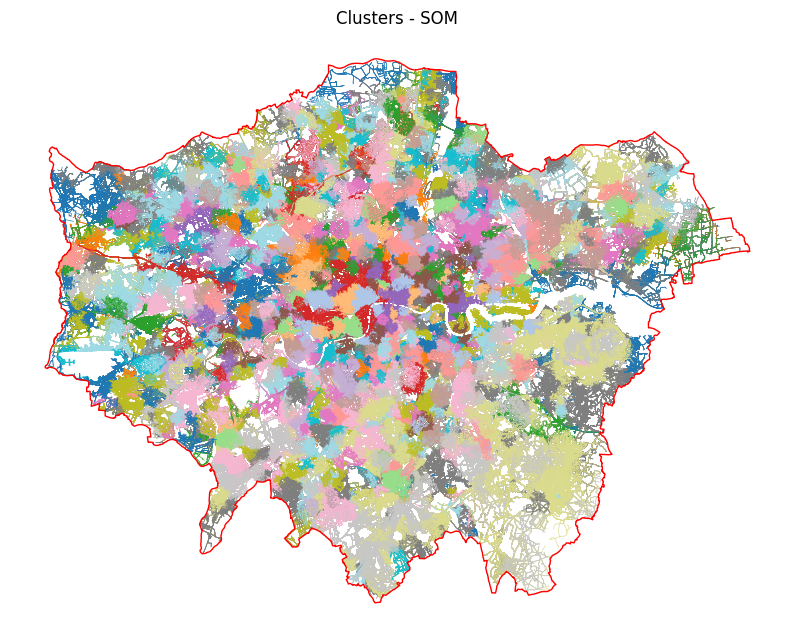

In [80]:
# clustering with SOM
from minisom import MiniSom

# standardize features
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

# train SOM
som = MiniSom(10, 10, len(features), sigma=1.0, learning_rate=0.5, random_seed=random_seed)
som.train_random(df[features].values, 1000)

# get cluster labels
labels = np.array([som.winner(x) for x in df[features].values])
df['cluster_som'] = [str(x[0]) + str(x[1]) for x in labels]

# visualize clusters
fig, ax = plt.subplots(figsize=(10,10))
df.plot(column='cluster_som', ax=ax, cmap='tab20')
london.boundary.plot(ax=ax, color='red', linewidth=1)

plt.title('Clusters - SOM')
plt.axis('off')
plt.show()

In [81]:
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 17342 entries, 0 to 17341
Data columns (total 39 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   id_code                    17342 non-null  object  
 1   geometry                   17342 non-null  geometry
 2   population                 17342 non-null  float64 
 3   poi_banking                17342 non-null  float64 
 4   poi_hotels                 17342 non-null  float64 
 5   poi_leisure_active         17342 non-null  float64 
 6   poi_leisure_entertainment  17342 non-null  float64 
 7   poi_leisure_outdoor        17342 non-null  float64 
 8   poi_medical                17342 non-null  float64 
 9   poi_nature                 17342 non-null  float64 
 10  poi_public_facilities      17342 non-null  float64 
 11  poi_religious              17342 non-null  float64 
 12  poi_restaurants            17342 non-null  float64 
 13  poi_shopping           